In [1]:
import logging
import os
import sys
import shutil
import tempfile
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ResizeWithPadOrCrop,
    RandAdjustContrast,
    RandBiasField,
    RandAffine,
    ScaleIntensity,
)
this_path = Path().resolve()

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# logging.basicConfig(stream=sys.stdout, level=logging.INFO)
# print_config()

In [2]:
# Set data directory
data_path = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'Data - PD: {pd_number}, HC: {hc_number}')

Data - PD: 49, HC: 23


In [25]:
# split

split_ratio = {'train': 0.6, 'val': 0.2, 'test': 0.2}

pd_subs = md_df.loc[md_df.group == 1, 'id'].values
hc_subs = md_df.loc[md_df.group == 0, 'id'].values

set_splits = {'train': {'pd': round(split_ratio['train'] * pd_number), 'hc': round(split_ratio['train'] * hc_number)},
                'val': {'pd': round(split_ratio['val'] * pd_number), 'hc': round(split_ratio['val'] * hc_number)}}
set_splits['test'] = {'pd': pd_number - (set_splits['train']['pd'] + set_splits['val']['pd']),
                        'hc': hc_number - (set_splits['train']['hc'] + set_splits['val']['hc'])}
# {'train': {'pd': 29, 'hc': 14},
#  'val': {'pd': 10, 'hc': 5},
#  'test': {'pd': 10, 'hc': 4}}

train_subs = list(pd_subs[:set_splits['train']['pd']]) + list(hc_subs[:set_splits['train']['hc']])
val_subs = list(pd_subs[set_splits['train']['pd']:(set_splits['train']['pd'] + set_splits['val']['pd'])]) + list(hc_subs[set_splits['train']['hc']:(set_splits['train']['hc'] + set_splits['val']['hc'])])
test_subs = list(pd_subs[-set_splits['test']['pd']:]) + list(hc_subs[-set_splits['test']['hc']:])

train_lab = [1 for i in range(set_splits['train']['pd'])] + [0 for i in range(set_splits['train']['hc'])]
val_lab = [1 for i in range(set_splits['val']['pd']-1)] + [0 for i in range(set_splits['val']['hc'])]
test_lab = [1 for i in range(set_splits['test']['pd'])] + [0 for i in range(set_splits['test']['hc'])]
print(f'Train subjs: {train_subs} \n', f'Val subjs: {val_subs} \n', f'Test subjs: {test_subs}')

Train subjs: ['sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-013', 'sub-014', 'sub-015', 'sub-016', 'sub-017', 'sub-018', 'sub-019', 'sub-021', 'sub-023', 'sub-024', 'sub-025', 'sub-029', 'sub-031', 'sub-035', 'sub-037', 'sub-038', 'sub-039', 'sub-040', 'sub-041', 'sub-042', 'sub-012', 'sub-020', 'sub-022', 'sub-026', 'sub-027', 'sub-028', 'sub-030', 'sub-032', 'sub-033', 'sub-034', 'sub-036', 'sub-044', 'sub-047', 'sub-048'] 
 Val subjs: ['sub-043', 'sub-045', 'sub-046', 'sub-049', 'sub-052', 'sub-053', 'sub-055', 'sub-056', 'sub-058', 'sub-059', 'sub-050', 'sub-051', 'sub-054', 'sub-057', 'sub-060'] 
 Test subjs: ['sub-061', 'sub-062', 'sub-063', 'sub-065', 'sub-066', 'sub-070', 'sub-071', 'sub-072', 'sub-073', 'sub-074', 'sub-064', 'sub-067', 'sub-068', 'sub-069']


In [26]:
# temporal fix
val_subs.pop(8)
val_subs

['sub-043',
 'sub-045',
 'sub-046',
 'sub-049',
 'sub-052',
 'sub-053',
 'sub-055',
 'sub-056',
 'sub-059',
 'sub-050',
 'sub-051',
 'sub-054',
 'sub-057',
 'sub-060']

In [27]:
subs = train_subs + val_subs
labels = torch.nn.functional.one_hot(torch.as_tensor(train_lab + val_lab)).float()
images = [(data_path/sub/'Results'/f'{sub}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_R2s_WLS1.nii') for sub in subs]

In [32]:
size = (200, 200, 176)
# Define transforms
# train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize(size), RandRotate90()]) # Resize(size)
comment = 'DA_02'
train_transforms = Compose([ScaleIntensity(),
                            EnsureChannelFirst(), 
                            ResizeWithPadOrCrop(size), 
                            # RandRotate90(),
                            RandAffine(prob=0.5,
                                        translate_range=(5, 5, 5),
                                        rotate_range=(np.pi * 4, np.pi * 4, np.pi *4 ),
                                        scale_range=(0.15, 0.15, 0.15),
                                        padding_mode='zeros')])
                            # RandAdjustContrast(),
                            # RandBiasField()]) # Resize(sget_max_shapeize)
val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), ResizeWithPadOrCrop(size)]) # , Resize(size)

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=3, num_workers=2, pin_memory=pin_memory)

im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)

# create a training data loader
train_ds = ImageDataset(image_files=images[:len(train_lab)], labels=labels[:len(train_lab)], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[-len(val_lab):], labels=labels[-len(val_lab):], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=pin_memory)

<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([3, 1, 200, 200, 176]) tensor([[0., 1.],
        [0., 1.],
        [0., 1.]]) torch.Size([3, 2])


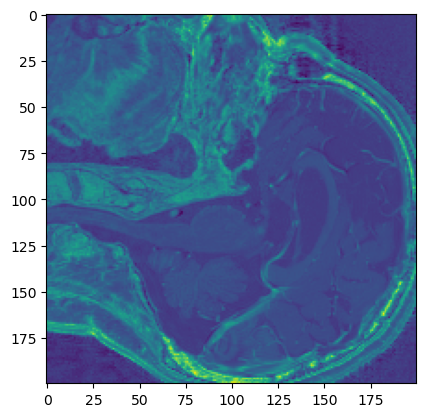

In [13]:
im, label = monai.utils.misc.first(check_loader)
plt.imshow(im[0].cpu().detach().numpy()[0, :, :, 89]) # , (1, 2, 3, 0)

In [34]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)

loss_function = torch.nn.CrossEntropyLoss()
# loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# start a typical PyTorch training
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter(comment=comment)
max_epochs = 100

In [35]:
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()

        num_correct = 0.0
        metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                metric_count += len(value)
                num_correct += value.sum().item()

        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
            print("saved new best metric model")

        print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/21, train_loss: 0.7093
2/21, train_loss: 0.6481
3/21, train_loss: 0.7906
4/21, train_loss: 0.6532
5/21, train_loss: 0.6343
6/21, train_loss: 0.6254
7/21, train_loss: 0.8205
8/21, train_loss: 0.5885
9/21, train_loss: 0.8768
10/21, train_loss: 0.3472
11/21, train_loss: 0.8911
12/21, train_loss: 0.5479
13/21, train_loss: 0.6429
14/21, train_loss: 1.1058
15/21, train_loss: 1.4038
16/21, train_loss: 0.5745
17/21, train_loss: 0.4756
18/21, train_loss: 0.5460
19/21, train_loss: 0.4912
20/21, train_loss: 0.5567
21/21, train_loss: 0.5110
22/21, train_loss: 0.4078
epoch 1 average loss: 0.6749
saved new best metric model
Current epoch: 1 current accuracy: 0.3571 
Best accuracy: 0.3571 at epoch 1
----------
epoch 2/100
1/21, train_loss: 0.4181
2/21, train_loss: 1.0838
3/21, train_loss: 0.3978
4/21, train_loss: 0.4561
5/21, train_loss: 0.5021
6/21, train_loss: 0.3590
7/21, train_loss: 0.9715
8/21, train_loss: 0.7358
9/21, train_loss: 0.5379
10/21, train_loss: 0.6635
11/21, 